In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer, KBinsDiscretizer, Binarizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

pd.set_option('display.max_rows', 500)

In [3]:
data = pd.read_csv("data_set.csv")
data.drop_duplicates(inplace=True, ignore_index=True)
bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
data['BMI_category'] = pd.cut(data['bmi'], bins=bins, labels=labels, right=False)
y = data["charges"]
# X = data.loc[:, data.columns != "charges"]
X = data.drop(["charges"], axis=1)

In [4]:
person = pd.read_csv("singlerow.csv")
person = person.drop(["charges"], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

print("Train set :", X_train.shape)
print("Test set :", X_test.shape)

Train set : (1136, 7)
Test set : (201, 7)


In [6]:
preprocessor = make_pipeline(make_column_transformer((StandardScaler(), ["children", "age", "bmi"]),
    (OrdinalEncoder(), ["smoker", "sex", "BMI_category"]), (OneHotEncoder(), ["region"])), PolynomialFeatures(2))                              

In [7]:
model = make_pipeline(preprocessor, Ridge(3.0303, random_state=42))


# grid = GridSearchCV(model, {"ridge__alpha": np.linspace(0, 100, 100), "pipeline__polynomialfeatures__interaction_only": [True, False]}, cv = 5)
# grid.fit(X_train, y_train)
# print(grid.best_params_)

model.fit(X_train, y_train)
# prediction = model.predict(person)

print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))
# print("Prédiction : ", prediction)

Train score :  0.8591852714428503
Test score :  0.9146164397976068


In [8]:
model = make_pipeline(preprocessor, Lasso(45, random_state=42))

# grid = GridSearchCV(model, {"lasso__alpha": np.linspace(1, 100, 100), "pipeline__polynomialfeatures__interaction_only": [True, False]}, cv = 5)
# grid.fit(X_train, y_train)
# print(grid.best_params_)

model.fit(X_train, y_train)

print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))

Train score :  0.8571118049450294
Test score :  0.916372389092918


In [9]:
model = make_pipeline(preprocessor, LinearRegression())

model.fit(X_train, y_train)

print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test)) 

Train score :  0.8593563098818566
Test score :  0.9140591572092801


In [10]:
model = make_pipeline(preprocessor, ElasticNet(45, l1_ratio=1, random_state=42))

model.fit(X_train, y_train)

print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))

# grid = GridSearchCV(model, {"elasticnet__alpha": np.linspace(1, 100, 100), "elasticnet__l1_ratio": np.linspace(0.01, 1, 10), 
#                             "pipeline__polynomialfeatures__interaction_only": [True, False]}, cv = 5, scoring="r2")
# grid.fit(X_train, y_train)
# print(grid.best_params_)

Train score :  0.8571118049450294
Test score :  0.916372389092918


In [11]:
# #Function for model evaluation
# def evaluation(model, test_features, test_labels, log_transformed=False):
#     predictions = model.predict(test_features)

#     # Calculate R²
#     r2 = model.score(test_features, test_labels)

#     # Calculate RMSE
#     rmse = np.sqrt(np.mean((predictions - test_labels) ** 2))

#     # Calculate MAPE (mean absolute percentage error) for accuracy
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape

#     return r2, rmse, accuracy

# results=[]
# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)

# # Evaluate both versions of the model
# r2, rmse, accuracy = evaluation(model, X_test, y_test, log_transformed=False)

# results.append({
# 'Model': "ElasticNet",
# 'R²': r2,
# 'MSE': mse,
# 'RMSE': rmse,
# 'Accuracy': accuracy,

#     })

# pd.DataFrame(results)

In [12]:
# pickle.dump(model, open("model.pickle", "wb"))

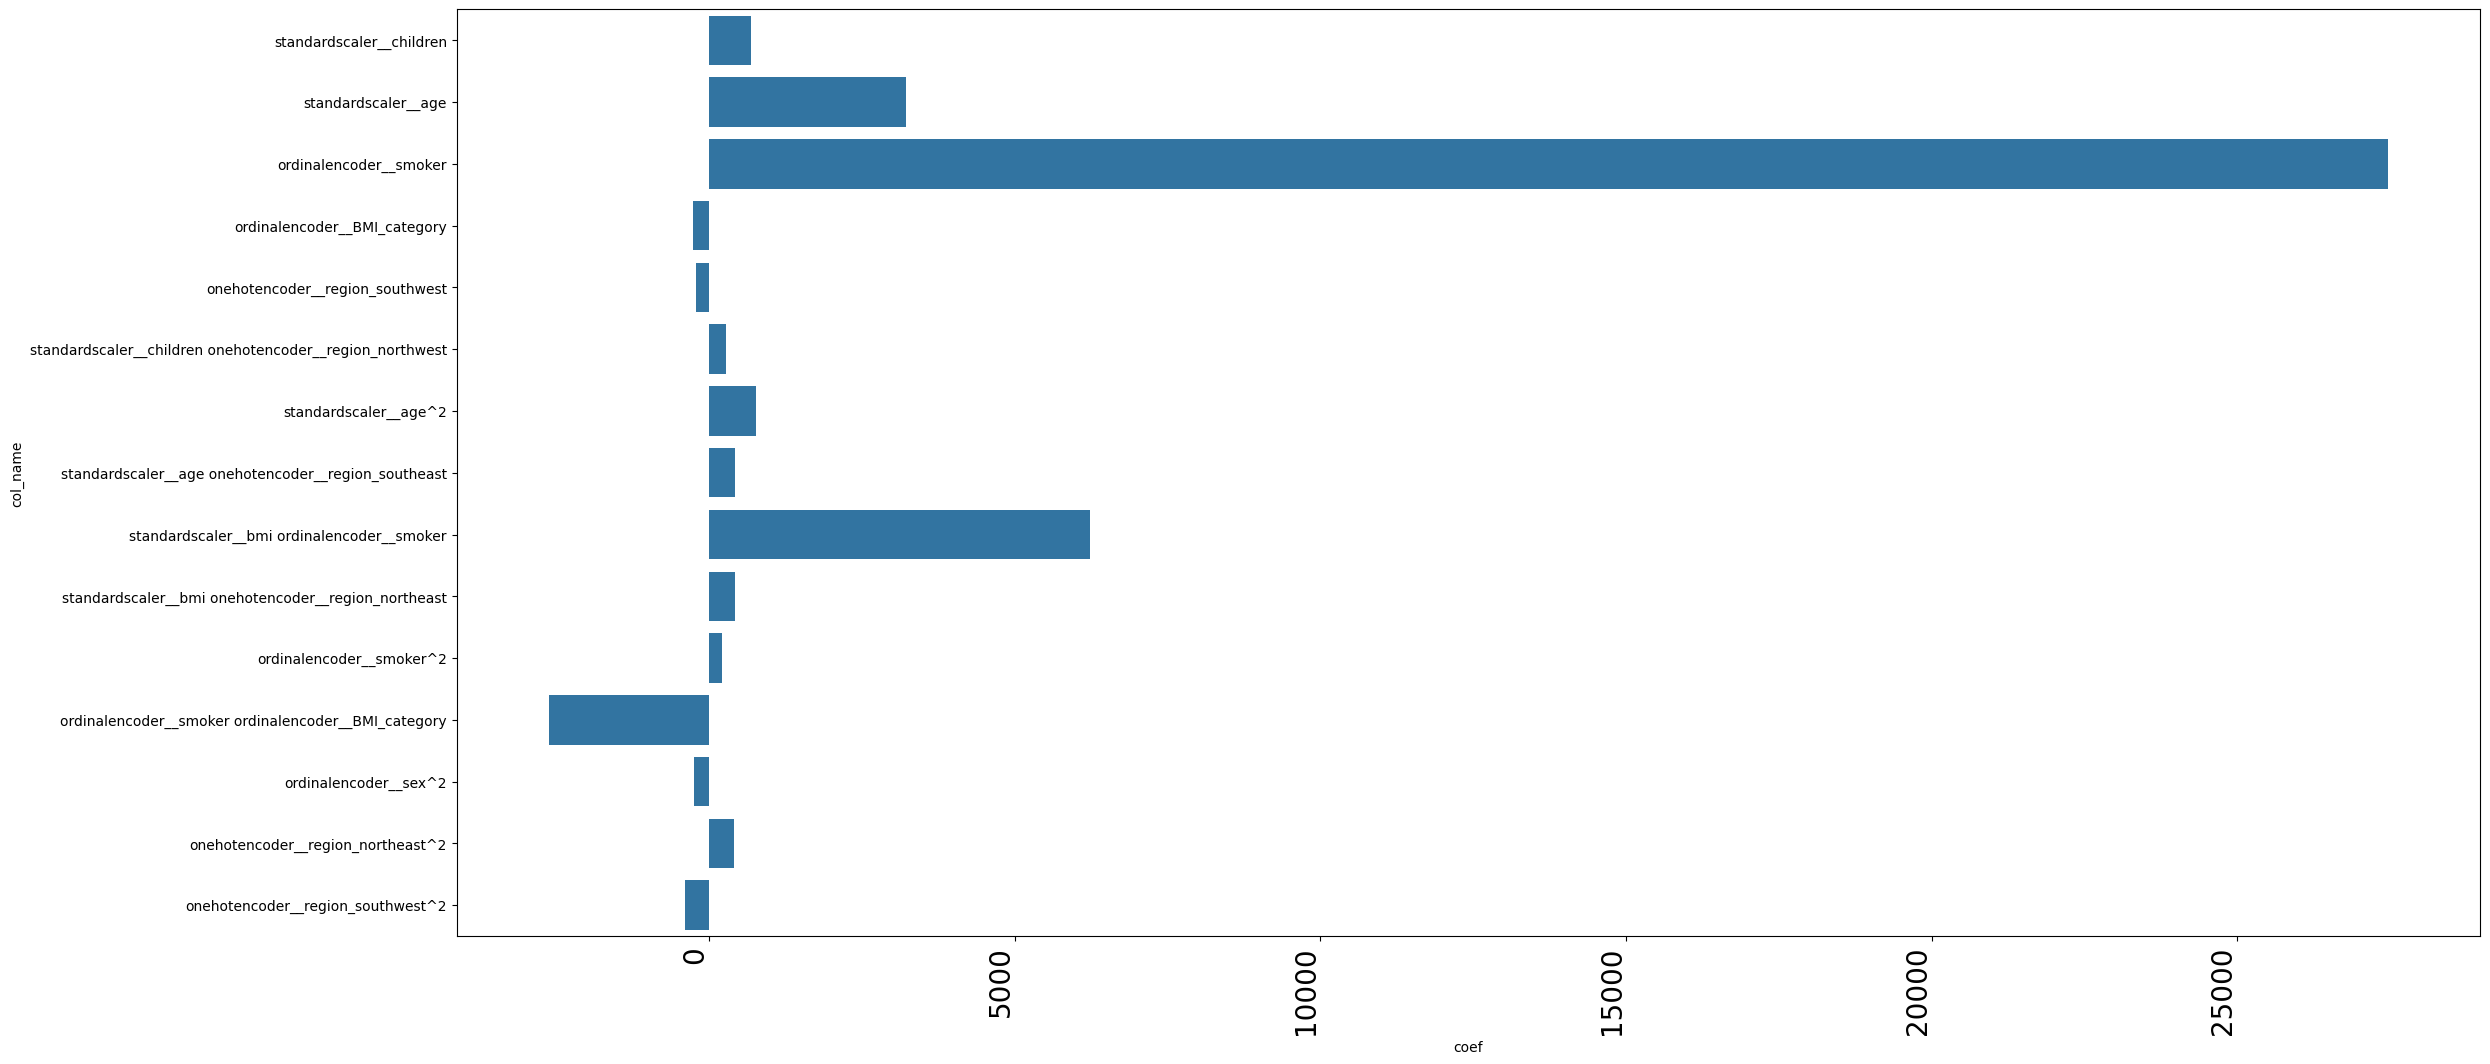

In [13]:
#Affiche un plot avec les poids de chaque colonnes. Les poids de 0 sont retirés.

coef_dict = {"col_name": model[-2].get_feature_names_out(), "coef": model[-1].coef_}
df_coef = pd.DataFrame(coef_dict)
df_coef = df_coef[(df_coef["coef"] > 200) | (df_coef["coef"] < -200)]
df_coef


plt.figure(figsize=(25,10))
sns.barplot(df_coef, x="coef", y="col_name", orient="h") 
plt.tight_layout()
plt.xticks(rotation = 90, ha = 'right', fontsize = 20)
plt.show()


[ 204  408  613  817 1022]


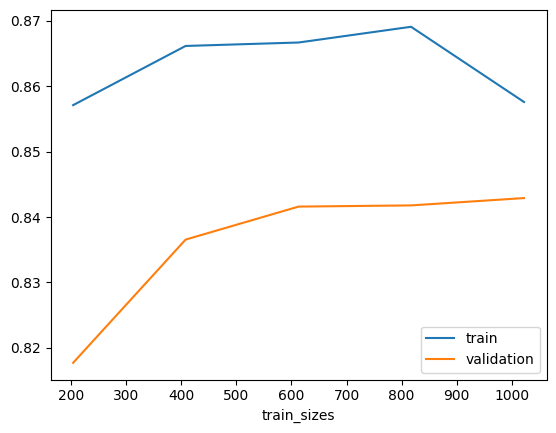

In [14]:
# cross_val_score(LinearRegression(), X_train, y_train, cv=5).mean()
N, train_score, val_score = learning_curve(model, X_train, y_train,train_sizes=np.linspace(0.2,1.0,5), cv=10, random_state=42)

print(N)
plt.plot(N, train_score.mean(axis=1), label="train")
plt.plot(N, val_score.mean(axis=1), label="validation")
plt.xlabel("train_sizes")
plt.legend()

In [24]:
print("Intercept du modèle : ", model[-1].intercept_)

Intercept du modèle :  8378.807892816109


In [25]:
df_2 = pd.DataFrame(coef_dict).sort_values(by="coef", ascending=False)

df_2.to_csv("coef.csv")